In [1]:
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

### Importando Dados

In [2]:
train_df = pd.read_csv('data/train_processed.csv')
test_df = pd.read_csv('data/test_processed.csv')

train_data, val_data = train_test_split(train_df, test_size=0.25, random_state=42)

In [3]:
train_df.head(10)

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,...,Arrival Delay in Minutes,Jovem,Adulto,Idoso,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,0.8,...,0.56250,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,0.2,...,0.18750,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.8,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,...,0.28125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,0.6,...,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.232027,0.6,0.8,0.4,0.2,0.2,0.4,0.2,0.2,0.6,...,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,0.251414,0.4,0.8,0.4,0.6,0.4,0.4,0.4,0.4,0.6,...,0.71875,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0.404685,0.8,0.6,0.8,0.8,1.0,1.0,1.0,1.0,1.0,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.165994,0.2,0.4,0.4,0.4,0.8,0.6,0.6,0.2,0.2,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.207997,0.6,0.6,0.6,0.8,0.4,0.6,0.6,0.4,0.4,...,0.00000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [4]:
train_df.dtypes

Flight Distance                      float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
Cleanliness                          float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Jovem                                float64
Adulto                               float64
Idoso                                float64
Gender_Male                          float64
Customer Type_disloyal Customer      float64
Type of Tr

### Criando os Datasets e DataLoaders

In [27]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row[:-1].values.astype('float32')
        label = row[-1].astype('int64')

        features = torch.tensor(features)
        label = torch.tensor(label)

        return features, label

In [20]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_df)

BATCH_SIZE = 32
#NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

### Funcoes auxiliares

In [8]:
# registrar os custos
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
# treinamento de uma epoca
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()

    train_loss = AverageMeter()
    for instances, labels in train_dl:
        # mover os dados para o device e fazer as previsoes
        instances = instances.to(device)
        labels = labels.to(device)
        logits = model(instances)

        # zerar os gradientes
        optimizer.zero_grad()

        # calcular o erro
        loss = criterion(logits, labels)
        train_loss.update(loss.item(), len(instances))

        # calcular os gradientes e atualizar os pesos
        loss.backward()
        optimizer.step()
    
    return train_loss.avg

In [10]:
# validacao
def validation_step(model, val_dl, criterion, device):
    model.eval()

    val_loss = AverageMeter()
    for instances, labels in val_dl:
        instances = instances.to(device)
        labels = labels.to(device)

        logits = model(instances)
        loss = criterion(logits, labels)

        val_loss.update(loss.item(), len(instances))

    return val_loss.avg

In [11]:
def train(model, train_dl, val_dl, criterion, optimizer, device, epochs):
    loss = {
        "train_loss": [],
        "val_loss": []
    }
    
    print_epochs = epochs // 5

    for epoch in range(1, epochs+1):
        train_loss = train_step(model, train_dl, criterion, optimizer, device)
        val_loss = validation_step(model, val_dl, criterion, device)

        loss["train_loss"].append(train_loss)
        loss["val_loss"].append(val_loss)

        if (epoch % print_epochs) == 0:
            print(f"Train loss: {round(train_loss, 6):<7}")
            print(f"Valid. loss: {round(val_loss, 6):<7}\n")

    # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
    update_graph = epochs//30
    if update_graph < 1:
        update_graph = 1

    # plotar o gráfico de loss
    fig = plt.figure()
    plt.title("Cross entropy loss")
    plt.plot(loss["train_loss"][::update_graph], c="g", label="train")
    plt.plot(loss["val_loss"][::update_graph], c="r", label="valid")
    plt.legend()

In [17]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(2))
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

### Classe da arquitetura


In [13]:
class MLP(nn.Module):
    def __init__(self, architecture):
        super(MLP, self).__init__()
        mlp_input_size = architecture['input_size']

        self.fc_layers = nn.ModuleList()
        
        for units in architecture['mlp']:
            self.fc_layers.append(nn.Linear(mlp_input_size, units['out_units']))
            if 'activation' in units:
                self.fc_layers.append(units['activation']())
            if 'dropout' in units:
                self.fc_layers.append(nn.Dropout(units['dropout']))
            mlp_input_size = units['out_units']

        self.output_layer = nn.Linear(mlp_input_size, architecture['output_units'])

    def forward(self, X):
        for layer in self.fc_layers:
            X = layer(X)
        
        X = self.output_layer(X)
        return X

In [14]:
def hyperparameter_search(train_dl, val_dl, test_dl, param_grid, device):
    best_accuracy = 0
    best_model = None
    loss_fn = nn.CrossEntropyLoss()

    for params in ParameterGrid(param_grid):
        print(f"Testing with parameters: {params}")

        model = MLP(params['architecture']).to(device)

        # hiperparametros como otimizador, learning rate e número de épocas são passados como entrada
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

        train(model, train_dl, val_dl, loss_fn, optimizer, device, params['epochs'])
        val_accuracy = test(model, test_dl, device)

        # salvar quais foram os parâmetros que deram melhor acurácia
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    return best_model, best_accuracy

Testing with parameters: {'architecture': {'input_size': 25, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 2}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'SGD'}


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_50401/1343700337.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[-1].astype('float32')


Train loss: 0.515767
Valid. loss: 0.4522 

Train loss: 0.406077
Valid. loss: 0.367837

Train loss: 0.372851
Valid. loss: 0.338555

Train loss: 0.353236
Valid. loss: 0.323844

Train loss: 0.340914
Valid. loss: 0.313489

              precision    recall  f1-score   support

           0     0.8363    0.9301    0.8807     14573
           1     0.8958    0.7673    0.8265     11403

    accuracy                         0.8586     25976
   macro avg     0.8660    0.8487    0.8536     25976
weighted avg     0.8624    0.8586    0.8569     25976



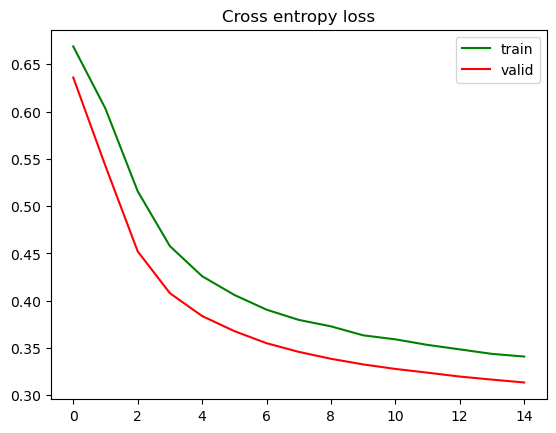

In [32]:
param_grid = {
    'architecture': [
        {
            'input_size': train_df.shape[1] - 1,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 1
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['SGD'],
    'epochs': [15]
}

best_model, best_accuracy = hyperparameter_search(train_loader, val_loader, test_loader, param_grid, device)

In [ ]:
print(f"Best parameters: {best_model.parameters()}")
print(f"Best validation accuracy: {best_accuracy:.4f}")